# BERT

By Alberto Valdés.

**Mail 1:** anvaldes@uc.cl

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

This notebook was devoloped in Google Colab using "V100 GPU".

**Requirements:**

$ $

pandas==2.0.3

tensorflow==2.9.3

tensorflow_hub==0.16.1

tensorflow_text==2.9.0

The BERT model was proposed in BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding by Jacob Devlin, Ming-Wei Chang, Kenton Lee and Kristina Toutanova. It’s a bidirectional transformer pretrained using a combination of masked language modeling objective and next sentence prediction on a large corpus comprising the Toronto Book Corpus and Wikipedia.

**Abstract**

We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models, BERT is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications.

BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement).

**Usage tips**

* BERT is a model with absolute position embeddings so it’s usually advised to pad the inputs on the right rather than the left.

* BERT was trained with the masked language modeling (MLM) and next sentence prediction (NSP) objectives. It is efficient at predicting masked tokens and at NLU in general, but is not optimal for text generation.

* Corrupts the inputs by using random masking, more precisely, during pretraining, a given percentage of tokens (usually 15%) is masked by:

* * a special mask token with probability 0.8
* * a random token different from the one masked with probability 0.1
* * the same token with probability 0.1

* The model must predict the original sentence, but has a second objective: inputs are two sentences A and B (with a separation token in between). With probability 50%, the sentences are consecutive in the corpus, in the remaining 50% they are not related. The model has to predict if the sentences are consecutive or not.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import time
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import image as mpimg

In [3]:
def display_img(name, a, b):
    plt.figure(figsize = (a, b))
    image = mpimg.imread(name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

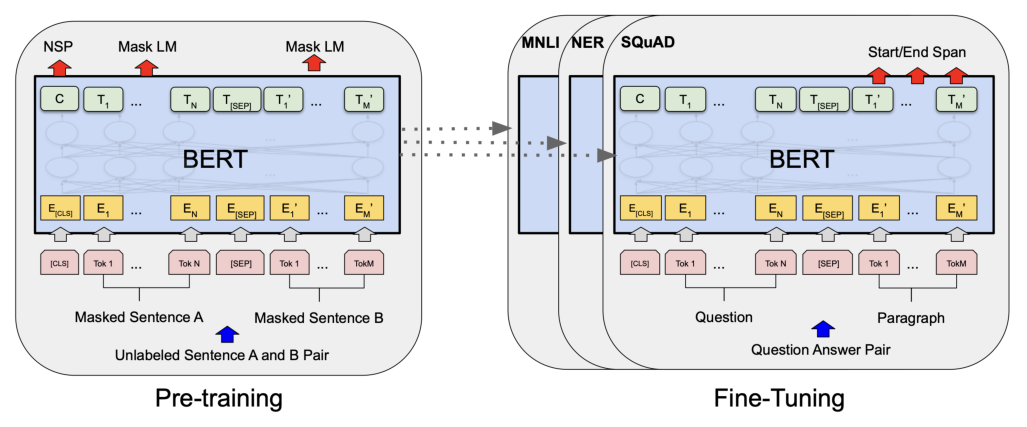

In [4]:
display_img('BERT_1.png', 13, 10)

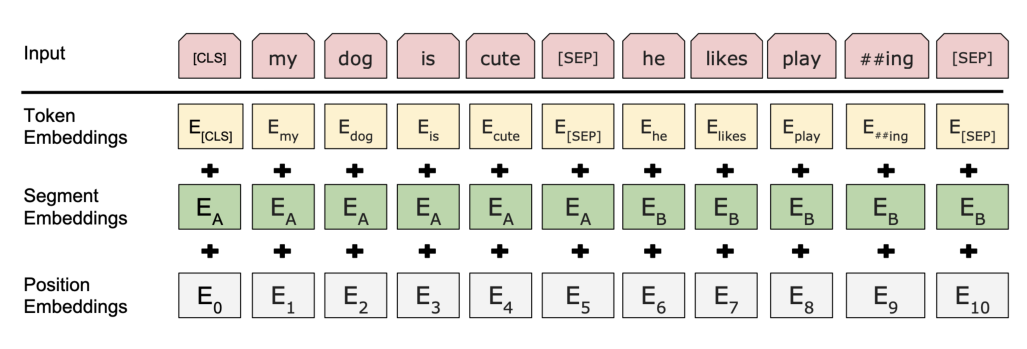

In [5]:
display_img('BERT_2.png', 13, 10)

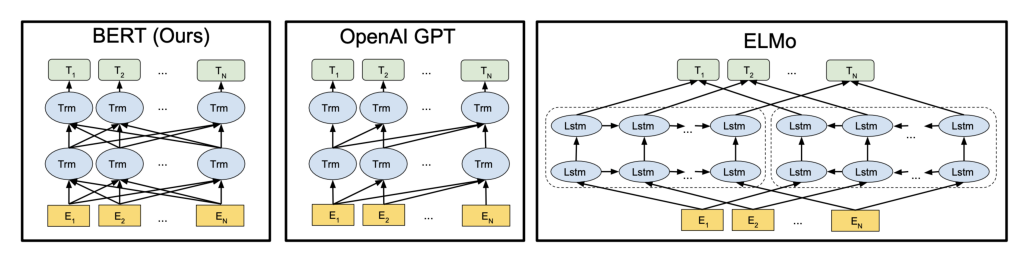

In [6]:
display_img('BERT_3.png', 13, 10)

# Finetunning

We are going to do a Finetunning using BERT to classify text massages. We will use the same dataset we used to train LTSM and GRU models.

In [7]:
start = time.time()

### a. Setting the environment

In [8]:
# !pip install -q pandas==2.0.3
# !pip install -q tensorflow_hub==0.16.1
# !pip install -q tensorflow==2.9.3
# !pip install -q tensorflow_text==2.9.0

### b. Import Libraries

In [9]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split

### c. Leer data

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
path = 'drive/MyDrive/Github_Alberto_Valdes/Deep_Learning/NLP/SMSSpamCollection'

In [12]:
df = pd.read_csv(path, sep='\t', names=["label", "message"])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
df.rename(columns = {'label':'Category', 'message':'Message'}, inplace = True)
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [15]:
df['spam'] = df['Category'].apply(lambda x: 1 if x == 'spam' else 0)
df.head()

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [16]:
df['spam'].value_counts()

spam
0    4825
1     747
Name: count, dtype: int64

In [17]:
round(df['spam'].value_counts(normalize = True)*100, 2)

spam
0    86.59
1    13.41
Name: proportion, dtype: float64

### d. Split dataset

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df[['Message']], df['spam'], stratify = df['spam'])

In [19]:
X_train.head()

,Message
5424,U horrible gal... U knew dat i was going out w...
2233,Nothing just getting msgs by dis name wit diff...
4602,FreeMsg: Txt: CALL to No: 86888 & claim your r...
2401,Hi! This is Roger from CL. How are you?
3285,ALRITE SAM ITS NIC JUST CHECKIN THAT THIS IS U...


In [20]:
from imblearn.over_sampling import RandomOverSampler

In [21]:
oversample = RandomOverSampler(random_state = 0)

In [22]:
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)

In [23]:
X_train = X_train['Message']
X_train_os = X_train_os['Message']

### e. Call the models

In [24]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [25]:
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [26]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [27]:
example = get_sentence_embeding(list(df['Message'][0:3]))

In [28]:
example.shape

TensorShape([3, 768])

### f. Modify the model

In [29]:
text_input = tf.keras.layers.Input(shape=(), dtype = tf.string, name = 'text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

In [30]:
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

In [31]:
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [32]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', 'AUC'])

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

### g. Training

In [34]:
n_epochs = 3

In [35]:
hist = model.fit(X_train_os, y_train_os, validation_data = (X_test, y_test), epochs = n_epochs, batch_size = 32)

Epoch 1/3
227/227 [==============================] - 840s 4s/step - loss: 0.4450 - accuracy: 0.8240 - auc: 0.9043 - val_loss: 0.3469 - val_accuracy: 0.8715 - val_auc: 0.9571
Epoch 2/3
227/227 [==============================] - 816s 4s/step - loss: 0.2858 - accuracy: 0.9041 - auc: 0.9618 - val_loss: 0.2187 - val_accuracy: 0.9253 - val_auc: 0.9703
Epoch 3/3
227/227 [==============================] - 809s 4s/step - loss: 0.2406 - accuracy: 0.9217 - auc: 0.9708 - val_loss: 0.2308 - val_accuracy: 0.9203 - val_auc: 0.9781


In [36]:
all_loss_train = hist.history['loss']
all_loss_val = hist.history['val_loss']
all_n_epochs = np.array([i for i in range(1, n_epochs + 1)])

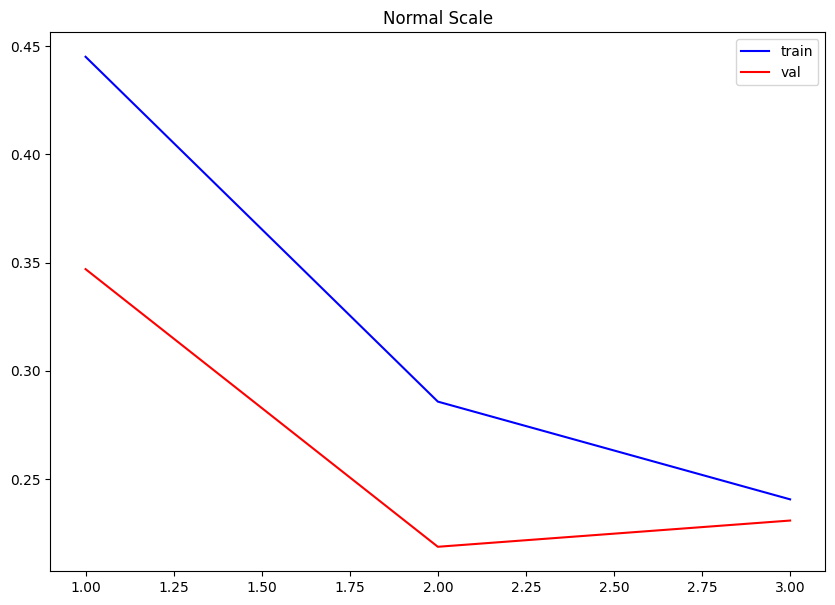

In [37]:
plt.figure(figsize = (10, 7))
plt.title('Normal Scale')
plt.plot(all_n_epochs, all_loss_train, color = 'blue', label = 'train')
plt.plot(all_n_epochs, all_loss_val, color = 'red', label = 'val')
plt.legend()
plt.show()

### h. Performance

In [38]:
y_test_pred_prob = model.predict(X_test)
y_test_pred_prob = y_test_pred_prob[:,0]

44/44 [==============================] - 134s 3s/step


In [39]:
y_test_pred_prob.mean()

0.2611781

In [40]:
y_test_pred = (y_test_pred_prob >= 0.5)*1

In [41]:
y_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [42]:
df_per = pd.DataFrame()
df_per['real'] = np.array(y_test)
df_per['pred'] = y_test_pred

In [43]:
df_per

,real,pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
1388,1,1
1389,0,0
1390,0,0
1391,0,0


In [44]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [45]:
round(precision_score(df_per['real'], df_per['pred'], average = 'macro')*100, 2)

81.39

In [46]:
round(recall_score(df_per['real'], df_per['pred'], average = 'macro')*100, 2)

92.91

### Time of execution

In [47]:
end = time.time()

In [48]:
delta = (end - start)

hours = int(delta/3600)
mins = int((delta - hours*3600)/60)
segs = int(delta - hours*3600 - mins*60)
print(f'Execute this notebook take us {hours} hours, {mins} minutes and {segs} seconds.')

Execute this notebook take us 0 hours, 43 minutes and 39 seconds.
